In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import zipfile
import os

ZIP_PATH = "/content/drive/MyDrive/dataswt_yolo.zip"   # <<< CHANGE THIS
EXTRACT_PATH = "/content/pet_dataset"          # Folder where data will be extracted

os.makedirs(EXTRACT_PATH, exist_ok=True)

with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
    zip_ref.extractall(EXTRACT_PATH)

print("ZIP extracted to:", EXTRACT_PATH)


ZIP extracted to: /content/pet_dataset


In [ ]:
DATASET_ROOT = "/content/pet_dataset/"

IMG_DIR = DATASET_ROOT + "images/images/"

XML_DIR = DATASET_ROOT + "annotations/annotations/xmls/"


In [ ]:
import os

xml_dir = "/content/pet_dataset/annotations/annotations/xmls"
print(os.listdir(xml_dir)[:10])  # prints first 10 files


['leonberger_142.xml', 'pomeranian_163.xml', 'boxer_163.xml', 'shiba_inu_125.xml', 'British_Shorthair_210.xml', 'staffordshire_bull_terrier_166.xml', 'great_pyrenees_126.xml', 'Abyssinian_122.xml', 'pug_141.xml', 'Ragdoll_152.xml']


In [ ]:
import os

# Get all image filenames (e.g., 'Abyssinian_1.jpg')
all_raw_images = [f for f in os.listdir(IMG_DIR) if f.endswith(".jpg")]

# Get all XML basenames (e.g., 'Abyssinian_1')
xml_basenames = set(f.replace(".xml", "") for f in os.listdir(XML_DIR))

# Filter images to only include those with a corresponding XML file
all_images = sorted([f for f in all_raw_images if f.replace(".jpg", "") in xml_basenames])

print("Total images with XMLs =", len(all_images))

Total images with XMLs = 3686


In [ ]:
from sklearn.model_selection import train_test_split

train_files, test_files = train_test_split(all_images, test_size=0.30, random_state=42)

print("Train =", len(train_files))
print("Test  =", len(test_files))

Train = 2580
Test  = 1106


In [ ]:
TRAINVAL = "/content/pet_dataset/annotations/annotations/trainval.txt"
TESTTXT  = "/content/pet_dataset/annotations/annotations/test.txt"


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import xml.etree.ElementTree as ET
import torchvision.transforms as T

class PetDataset(Dataset):
    def __init__(self, files, img_dir, xml_dir):
        self.files = files
        self.img_dir = img_dir
        self.xml_dir = xml_dir
        self.transform = T.ToTensor() # Default transform to convert PIL Image to Tensor

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        fname = self.files[idx]
        img_path = os.path.join(self.img_dir, fname)
        xml_path = os.path.join(self.xml_dir, fname.replace(".jpg", ".xml"))

        img = Image.open(img_path).convert("RGB")

        # Read XML
        tree = ET.parse(xml_path)
        root = tree.getroot()

        boxes = []
        labels = []

        for obj in root.findall("object"): # Iterate over all objects
            bndbox = obj.find("bndbox")
            xmin = float(bndbox.find("xmin").text)
            ymin = float(bndbox.find("ymin").text)
            xmax = float(bndbox.find("xmax").text)
            ymax = float(bndbox.find("ymax").text)
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(1)  # Use 1 for all objects (assuming a single class for pets)

        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((len(boxes),), dtype=torch.int64) # Assuming no crowd instances

        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": image_id,
            "area": area,
            "iscrowd": iscrowd
        }

        img = self.transform(img)

        return img, target

In [ ]:
# No need to define transform = T.ToTensor() here as it's handled internally by PetDataset
# import torchvision.transforms as T
# transform = T.ToTensor() # This line can be removed

train_ds = PetDataset(train_files, IMG_DIR, XML_DIR) # No 'transforms' argument passed for ToTensor
test_ds  = PetDataset(test_files,  IMG_DIR, XML_DIR)

train_loader = DataLoader(train_ds, batch_size=4, shuffle=True,
                          collate_fn=lambda x: tuple(zip(*x)))
test_loader  = DataLoader(test_ds, batch_size=4, shuffle=False,
                          collate_fn=lambda x: tuple(zip(*x)))

In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes=2)

model.to(device)


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


100%|██████████| 160M/160M [00:00<00:00, 168MB/s]


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
import os

print("Listing annotation folder:")
print(os.listdir("/content/pet_dataset/annotations/"))

print("\nListing inside annotations/* :")
for item in os.listdir("/content/pet_dataset/annotations/"):
    p = "/content/pet_dataset/annotations/" + item
    if os.path.isdir(p):
        print(f"{item}/ → {os.listdir(p)[:10]}")


Listing annotation folder:
['annotations']

Listing inside annotations/* :
annotations/ → ['trainval.txt', 'xmls', 'README', 'test.txt', 'trimaps', 'list.txt', '._trimaps']


In [ ]:
import os

IMAGE_DIR = "/content/pet_dataset/images"
XML_DIR = "/content/pet_dataset/annotations/annotations/xmls"

# List of XML basenames (without .xml)
xml_basenames = set(f.replace(".xml", "") for f in os.listdir(XML_DIR))

# Only keep images that have matching XMLs
imgs = [f for f in os.listdir(IMAGE_DIR) if f.replace(".jpg", "") in xml_basenames]

print(f"Number of images with XMLs: {len(imgs)}")
print("Sample images:", imgs[:10])


Number of images with XMLs: 0
Sample images: []


In [ ]:
import os

print(os.listdir("/content/pet_dataset/annotations/"))        # should show ['annotations']
print(os.listdir("/content/pet_dataset/annotations/annotations/"))  # should show ['xmls', 'README', ...]
print(os.listdir("/content/pet_dataset/annotations/annotations/xmls")[:10])  # first 10 XML files


['annotations']
['trainval.txt', 'xmls', 'README', 'test.txt', 'trimaps', 'list.txt', '._trimaps']
['leonberger_142.xml', 'pomeranian_163.xml', 'boxer_163.xml', 'shiba_inu_125.xml', 'British_Shorthair_210.xml', 'staffordshire_bull_terrier_166.xml', 'great_pyrenees_126.xml', 'Abyssinian_122.xml', 'pug_141.xml', 'Ragdoll_152.xml']


In [ ]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import xml.etree.ElementTree as ET
import torchvision.transforms as T # Import T here for ToTensor

class PetDataset(Dataset):
    def __init__(self, files, image_dir, xml_dir, transforms=None):
        self.files = files
        self.image_dir = image_dir
        self.xml_dir = xml_dir
        self.to_tensor = T.ToTensor() # Internal ToTensor for image
        self.transforms = transforms # For other image/target transforms (if any)

        # No need to filter here again, `files` should already be filtered
        # from the previous step where `all_images` was created.
        self.images = files

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.image_dir, img_name)
        xml_path = os.path.join(self.xml_dir, img_name.replace(".jpg", ".xml"))

        img = Image.open(img_path).convert("RGB")

        # Parse XML
        tree = ET.parse(xml_path)
        root = tree.getroot()

        boxes = []
        labels = []

        for obj in root.findall("object"):
            bndbox = obj.find("bndbox")
            box = [
                int(bndbox.find("xmin").text),
                int(bndbox.find("ymin").text),
                int(bndbox.find("xmax").text),
                int(bndbox.find("ymax").text),
            ]
            boxes.append(box)
            labels.append(1)  # use 1 for all objects

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        # The target dictionary needs image_id, area, iscrowd for Faster R-CNN
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((len(boxes),), dtype=torch.int64)

        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": image_id,
            "area": area,
            "iscrowd": iscrowd
        }

        # Apply ToTensor to the image first
        img = self.to_tensor(img)

        if self.transforms: # Apply any additional custom transforms that handle both img and target
            img, target = self.transforms(img, target)

        return img, target

In [ ]:
import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Load pre-trained Faster R-CNN model
model = fasterrcnn_resnet50_fpn(weights="DEFAULT")

# Replace the classifier with the correct number of classes (2 = background + object)
num_classes = 2
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

model.to(device)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

# Number of epochs
epochs = 3

# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0.0

    for imgs, tgts in train_loader:
        # Skip any batch that is empty
        if len(imgs) == 0:
            continue

        # Move images and targets to device
        imgs = [img.to(device) for img in imgs]
        tgts = [{k: v.to(device) for k, v in t.items()} for t in tgts]

        # Forward pass
        loss_dict = model(imgs, tgts)
        loss = sum(loss_dict.values())

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader) if len(train_loader) > 0 else 0
    print(f"Epoch [{epoch+1}/{epochs}] Loss = {avg_loss:.4f}")

Epoch [1/3] Loss = 0.2089
Epoch [2/3] Loss = 0.1642
Epoch [3/3] Loss = 0.1591


In [ ]:

torch.save(model.state_dict(), "fasterrcnn_pet.pth")
print("✔ Model saved as fasterrcnn_pet.pth")


✔ Model saved as fasterrcnn_pet.pth


In [ ]:
def show_prediction(model, img_name):
    model.eval()

    img_path = f"{IMG_SRC}/{img_name}"
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    h, w, _ = img_rgb.shape
    resized = cv2.resize(img_rgb, (480, 480))
    t = torch.tensor(resized/255., dtype=torch.float32).permute(2,0,1).unsqueeze(0).to(device)

    pred = model(t)[0]
    boxes = pred["boxes"].detach().cpu().numpy()
    scores = pred["scores"].detach().cpu().numpy()

    for box, score in zip(boxes, scores):
        if score < 0.5:
            continue
        x1,y1,x2,y2 = box.astype(int)
        cv2.rectangle(resized, (x1,y1), (x2,y2), (255,0,0), 2)
        cv2.putText(resized, f"{score:.2f}", (x1,y1-5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,0,0), 2)

    plt.figure(figsize=(6,6))
    plt.imshow(resized)
    plt.title("Faster R-CNN Prediction")
    plt.axis("off")
    plt.show()


Testing on: basset_hound_172.jpg


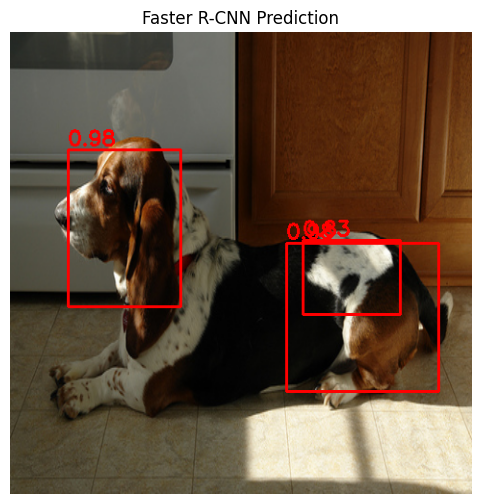

In [ ]:
import random
import cv2
import matplotlib.pyplot as plt

test_img = random.choice(test_files)
print("Testing on:", test_img)

def show_prediction(model, img_name):
    model.eval()

    img_path = f"{IMG_DIR}/{img_name}"
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    h, w, _ = img_rgb.shape
    resized = cv2.resize(img_rgb, (480, 480))
    t = torch.tensor(resized/255., dtype=torch.float32).permute(2,0,1).unsqueeze(0).to(device)

    pred = model(t)[0]
    boxes = pred["boxes"].detach().cpu().numpy()
    scores = pred["scores"].detach().cpu().numpy()

    for box, score in zip(boxes, scores):
        if score < 0.5:
            continue
        x1,y1,x2,y2 = box.astype(int)
        cv2.rectangle(resized, (x1,y1), (x2,y2), (255,0,0), 2)
        cv2.putText(resized, f"{score:.2f}", (x1,y1-5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,0,0), 2)

    plt.figure(figsize=(6,6))
    plt.imshow(resized)
    plt.title("Faster R-CNN Prediction")
    plt.axis("off")
    plt.show()

show_prediction(model, test_img)